## Import library

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import yaml
import re
import matplotlib.pyplot as plt
import os
import time
# print(os.getcwd())
# os.chdir("NLP_ENSAE_Project/")
# os.getcwd()

pd.set_option('future.no_silent_downcasting', True)

## Load data and tokens

In [2]:
!cd NLP_ENSAE_Project
with open(f'../data/entities.json', 'r') as file:
    data = json.load(file)

with open(f'../data/tokens.yml', 'r') as file:
    tokens = yaml.safe_load(file)
    
token_dict = {}
for col in tokens.keys():
    token = tokens[col]['start']
    token_dict[token] = col

token_dict

/bin/bash: line 1: cd: NLP_ENSAE_Project: No such file or directory


{'Ⓐ': 'age',
 'Ⓑ': 'birth_date',
 'Ⓒ': 'civil_status',
 'Ⓓ': 'education_level',
 'Ⓔ': 'employer',
 'Ⓕ': 'firstname',
 'Ⓗ': 'link',
 'Ⓘ': 'lob',
 'Ⓙ': 'maiden_name',
 'Ⓚ': 'nationality',
 'Ⓛ': 'observation',
 'Ⓜ': 'occupation',
 'Ⓞ': 'surname',
 'Ⓟ': 'surname_household'}

## Some Useful functions in my own .py

In [3]:
os.chdir("../")
from src.useful_functions import *

## Encode through pre-trained model

In [4]:
df = get_preprocessing_done(data, tokens,  token_dict)
df = df.reset_index()
df = df.rename(columns={"surname_household": "Is_household"})
X = df.drop(columns=['Is_household'])
y = df['Is_household'].apply(
                                lambda x: 0 if pd.isna(x) else 1
                            )
X_str = np.array([' '.join([str(x) for x in X.iloc[i].dropna(inplace=False).values]) for i in range(len(X))], dtype=str)

X_train, X_test, y_train, y_test = train_test_split(X_str, y, test_size=0.20, stratify=y)

100%|██████████| 1218/1218 [00:00<00:00, 2043.73it/s]


In [5]:
X_str

array(['0 25 Garçon Cyrille française menuisier Breton',
       '1 30 Garçon Auguste Piémontaise vitrier',
       '2 24 Garçon Pierre Piémontaise vitrier', ...,
       '25435 1886 Baretto Nello chef Castel italienne manoeuvre',
       '25436 1887 Annunziata épouse idem idem Berni-Laureti',
       '25437 1914 Primo fils idem idem Berni'], dtype='<U220')

## Full retrain

In [9]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

# Step 1: Preprocess Data
# Assuming X is a list of text sequences and y is a list of corresponding labels

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the input sequences
tokenized_texts = tokenizer(np.array(X_train).tolist(), padding=True, truncation=True, return_tensors='pt', max_length=512, add_special_tokens=True)

# Step 2: Load Pretrained Model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Step 3: Fine-tuning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# Step 4: Training
labels = torch.tensor(np.array(y_train))
dataset = TensorDataset(tokenized_texts['input_ids'], tokenized_texts['attention_mask'], labels)
train_dataloader = DataLoader(dataset, sampler=RandomSampler(dataset), batch_size=4)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
num_epochs = 1

start = time.time()
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print("Epoch:", epoch, " Loss:", total_loss)

stop = time.time()

# Count the number of trainable parameters
num_params_to_learn = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters to be learned: " + str(num_params_to_learn))
print(f"Training time: {round(stop - start,3)}s")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda
Epoch: 0  Loss: 564.5017843144306
Number of parameters to be learned: 109483778
Training time: 653.844s


Inference time: 21.932s
Accuracy: 0.9810568295114656
Classification report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3887
           1       0.98      0.93      0.96      1128

    accuracy                           0.98      5015
   macro avg       0.98      0.96      0.97      5015
weighted avg       0.98      0.98      0.98      5015



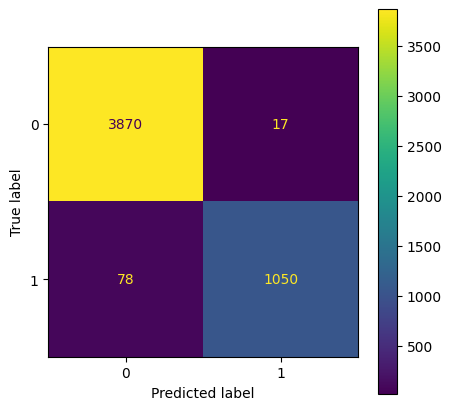

In [10]:
get_report_hugging_face_model(device, model, tokenizer, X_test, y_test)

# Only fine-tune the last classification layer

In [6]:
# Step 1: Preprocess Data
# Assuming X is a list of text sequences and y is a list of corresponding labels

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the input sequences
tokenized_texts = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors='pt', max_length=512, add_special_tokens=True)

# Step 2: Load Pretrained Model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Step 3: Freeze Pretrained Layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classification head
for param in model.classifier.parameters():
    param.requires_grad = True

# Step 4: Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

# Step 5: Training
labels = torch.tensor(np.array(y_train))
dataset = TensorDataset(tokenized_texts['input_ids'], tokenized_texts['attention_mask'], labels)
train_dataloader = DataLoader(dataset, sampler=RandomSampler(dataset), batch_size=4)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
num_epochs = 1

start = time.time()
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print("Epoch:", epoch, " Loss:", total_loss)

stop = time.time()

# Count the number of trainable parameters
num_params_to_learn = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters to be learned: " + str(num_params_to_learn))
print(f"Training time: {round(stop - start,3)}s")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda
Epoch: 0  Loss: 2319.6891377680004
Number of parameters to be learned: 1538
Training time: 145.48s


Inference time: 22.003s
Accuracy: 0.8412761714855433
Classification report
              precision    recall  f1-score   support

           0       0.84      0.98      0.91      3887
           1       0.86      0.35      0.50      1128

    accuracy                           0.84      5015
   macro avg       0.85      0.67      0.70      5015
weighted avg       0.84      0.84      0.81      5015



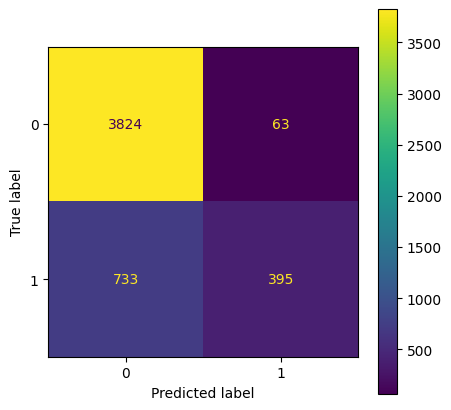

In [8]:
get_report_hugging_face_model(device, model, tokenizer, X_test, y_test)